In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from statsmodels.distributions.empirical_distribution import ECDF

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [34]:
data = pd.read_csv('interpret.csv')

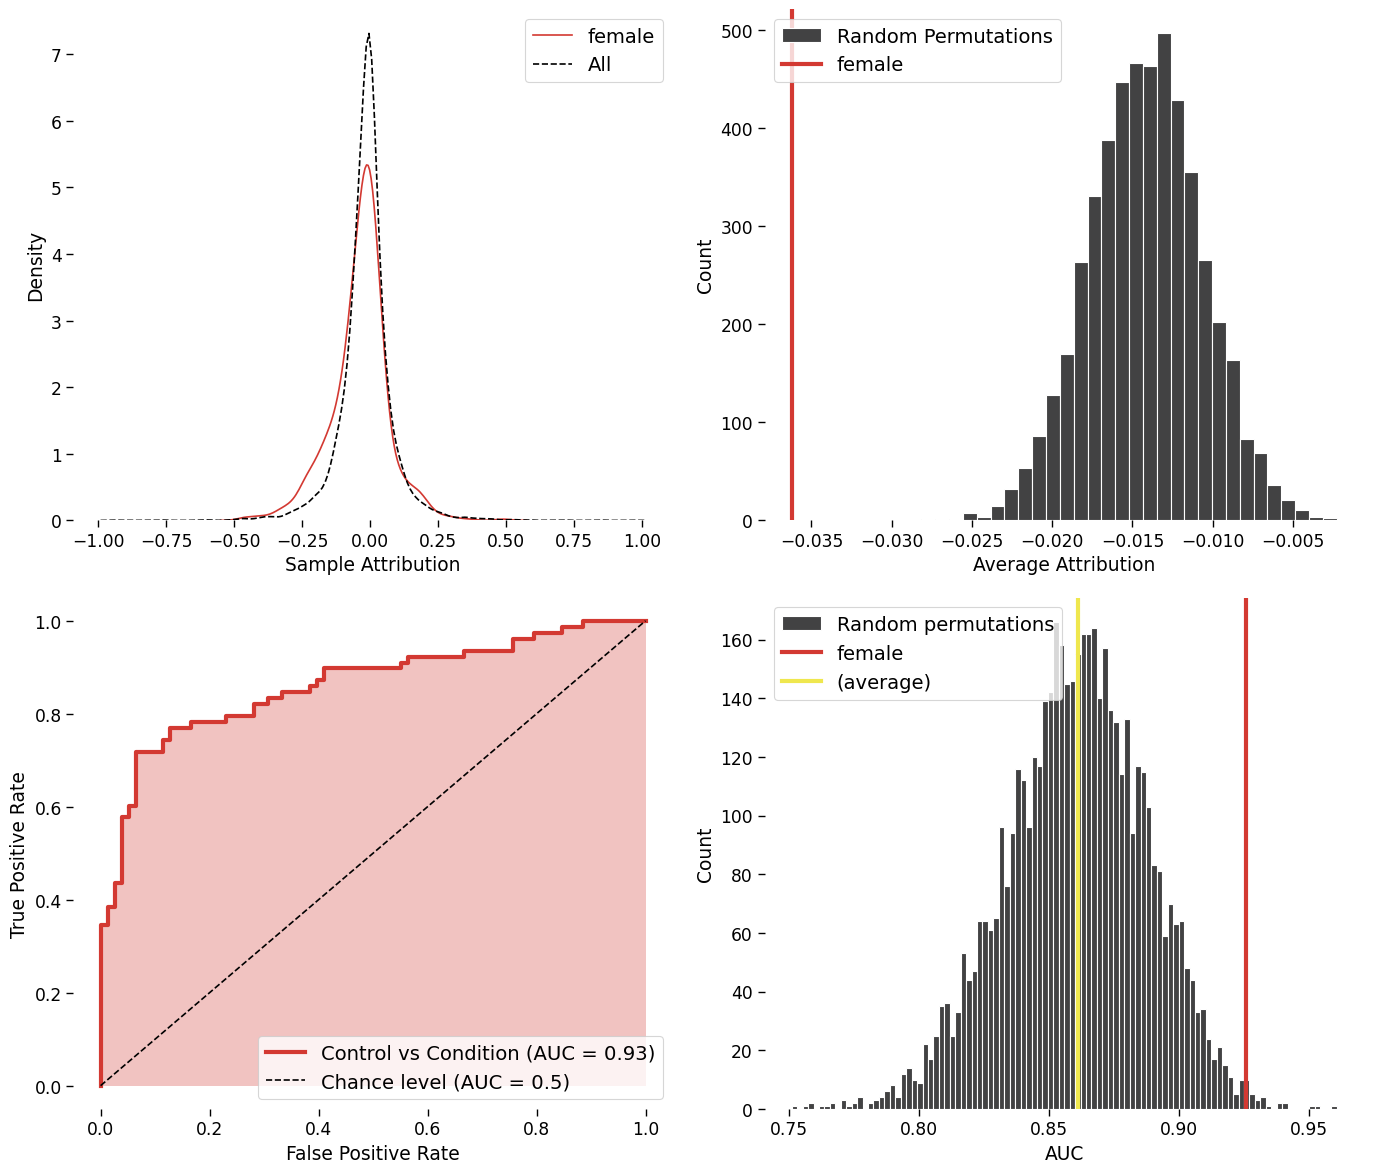

In [43]:
feature, AUC_impact, AUC, group, attr, count, percentile, AUC_random = [], [], [], [], [], [], [], []

for i in data.select_dtypes(include='number'):   
    
    feature.append(i)
    
    attribute = data.attribution.where(data[i] > 0)
    
    count.append(np.sum(data[i]))

    randv = 5000
    mask = data[i]
    attmeanrand = [np.mean(data.attribution.where(np.random.permutation(mask) > 0)) for xxx in np.arange(randv)]
    xxx = np.mean(data.attribution.where(mask > 0))
    
    attr.append(xxx)
    
    if (xxx > np.percentile(attmeanrand, 95)) or (xxx < np.percentile(attmeanrand, 5)):
        if xxx <= 0:
            group.append('control')
        else:
            group.append('condition')
            
    else:
        group.append('none')
            

    data['temp'] = data.attribution * mask
    XXX = data.groupby(['id']).mean()['temp'].to_numpy()
    yyy = data.groupby(['id']).median()['group'].to_numpy()
    fpr, tpr, thresholds = metrics.roc_curve(yyy, XXX)
    realp = metrics.auc(fpr, tpr)
    
    AUC.append(realp)
    
    ppp = np.zeros(randv)
    for ii in np.arange(randv):
        data['temp'] = data.attribution * np.random.permutation(mask)
        XXX = data.groupby(['id']).mean()['temp'].to_numpy()
        fpr, tpr, thresholds = metrics.roc_curve(yyy, XXX)
        ppp[ii] = metrics.auc(fpr, tpr)
    
    AUC_random.append(np.percentile(ppp, 50))
    percentile.append(ECDF(ppp)(realp))
    
    if (realp > np.percentile(ppp, 95)):
        AUC_impact.append('positive')
    elif (realp < np.percentile(ppp, 5)):
        AUC_impact.append('negative')
        
    else: AUC_impact.append('none')

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    sns.set_context(context='paper', font_scale=1.6)

    # 1st plot: Density plot of feature attribution and random distribution
    sns.kdeplot(attribute, label=i, ax=axs[0, 0], color= '#d33932')
    sns.kdeplot(data.attribution, label='All', ax=axs[0, 0], color='black', linestyle='dashed')
    axs[0, 0].set_xlabel('Sample Attribution')
    axs[0, 0].set_ylabel('Density')
    axs[0, 0].legend()
    axs[0, 0].set_frame_on(False)


    # 2nd plot: Histogram of average attribution of random distributions
    axs[0, 1].hist(attmeanrand, bins=30, label = 'Random Permutations', color='#424243', edgecolor='white')
    axs[0, 1].axvline(xxx, label = i, color='#d33932', linewidth=3)
    axs[0, 1].set_xlabel('Average Attribution')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].legend()
    axs[0, 1].set_frame_on(False)

    
    # 3rd plot: ROC curve of condition vs control
    axs[1, 0].plot(fpr, tpr, color='#d33932', lw = 3, label=f'Control vs Condition (AUC = {realp:.2f})')
    axs[1, 0].plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')  # Diagonal line
    axs[1, 0].set_xlabel('False Positive Rate')
    axs[1, 0].set_ylabel('True Positive Rate')
    axs[1, 0].fill_between(fpr, tpr, facecolor='#d33932', alpha=.3)
    axs[1, 0].legend()
    axs[1, 0].set_frame_on(False)

    
    # 4th plot: Histogram of AUC values of random distributions
    axs[1, 1].hist(ppp, bins = 100, label = 'Random permutations', color='#424243', edgecolor='white')
    axs[1, 1].axvline(realp, label = i, color='#d33932', lw=3)
    axs[1, 1].axvline(np.percentile(ppp, 50), label = '(average)', color='#efe74e', lw=3)
    axs[1, 1].set_xlabel('AUC')
    axs[1, 1].set_ylabel('Count')
    axs[1, 1].legend()
    axs[1, 1].set_frame_on(False)

    
    # Final adjustments
    plt.tight_layout()
    plt.rcParams['pdf.fonttype'] = 42 
    plt.show()
